# DM - Classification [TASK 3]

Library imports and initial settings.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from wittgenstein import RIPPER
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC

from tensorflow import keras
from scikeras.wrappers import KerasClassifier

from utils import fetch_preprocessed_dataset, store_preprocessed_dataset, build_grid_plot

import sys
import logging as lg
import warnings

warnings.filterwarnings("ignore")

root = lg.getLogger()
root.setLevel(lg.INFO)

handler = lg.StreamHandler(sys.stdout)
handler.setLevel(lg.DEBUG)
formatter = lg.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
root.addHandler(handler)

Fetching users_num dataset saved in clustering phase.

In [2]:
# Load the users_num dataset from csv
dataset = fetch_preprocessed_dataset(step_name="users_total")
users_num = dataset['users_num.csv']

`users_num` is a dataset composed by numerical attributes of `users`.

In [3]:
users_num.info

<bound method DataFrame.info of        Unnamed: 0  statuses_count  bot  tweets_num  tweets_2020_num  \
0               0              76    1         118              118   
1               1              54    0         104              104   
2               2               3    1           3                3   
3               3              50    1        1253             1253   
4               4            7085    0        3217             3217   
...           ...             ...  ...         ...              ...   
11503       11503            1126    0         991              991   
11504       11504            3024    0        1853             1853   
11505       11505               6    0           6                6   
11506       11506              42    1          91               91   
11507       11507            5279    0        3301             3301   

       likes_num  comments_num  ratio_likes_x_tweets   entropy  \
0            5.0           0.0              0.042

## Dataset preparation

Splitting dataset in training and test set. Each of the two part is a couple of input values and labels.

In [4]:
dataset = users_num.copy()
label = dataset.pop('bot')
train_set, test_set, train_label, test_label = train_test_split(dataset, label, stratify =label, test_size=0.20)

print("train_set:", train_set.shape)
print("train_label:", train_label.shape)
print("test_set:", test_set.shape)
print("test_label:", test_label.shape)

train_set: (9206, 12)
train_label: (9206,)
test_set: (2302, 12)
test_label: (2302,)


## Classification models

In [5]:
predictions = {}

In [6]:
scaler = MinMaxScaler()
scaler.fit(train_set, test_set)

train_set_scaled = scaler.transform(train_set)
test_set_scaled = scaler.transform(test_set)

In [7]:
def gridsearch(train_set, train_label, model, param_grid):
    gs = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=4)
    return gs.fit(train_set, train_label)

In [8]:
def report_scores(train_pred, test_pred, tr_label=train_label, ts_label=test_label):
    print("TRAIN")
    print(metrics.classification_report(tr_label,
                            train_pred,
                            target_names=['user', 'bot']))
    print("TEST")
    print(metrics.classification_report(ts_label,
                            test_pred,
                            target_names=['user', 'bot']))

In [9]:
def plot_cms(train_pred, test_pred, tr_label=train_label, ts_label=test_label):
    def plot_cm(title, label, pred):
        cm = metrics.confusion_matrix(label, pred)
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['user', 'bot'])
        disp.plot()
        disp.ax_.set_title(title)

    plot_cm("TRAIN", tr_label, train_pred)
    plot_cm("TEST", ts_label, test_pred)

### Decision tree

In [10]:
params = dict(
    max_depth=[5, 10, 20, 30, 40, 50],
    min_samples_leaf=[1, 2, 3, 4, 5]
)
dt = DecisionTreeClassifier(criterion='gini', splitter='best')
scores = gridsearch(train_set, train_label, dt, params)

scores

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 3, 4, 5]})

In [11]:
scores.best_params_

{'max_depth': 10, 'min_samples_leaf': 5}

In [12]:
dt = DecisionTreeClassifier(criterion='gini', splitter='best', **scores.best_params_)
dt.fit(train_set, train_label)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5)

In [13]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

predictions["Decision tree"] = (train_pred_dt, test_pred_dt)

In [14]:
report_scores(train_pred_dt, test_pred_dt)

TRAIN
              precision    recall  f1-score   support

        user       0.97      0.73      0.83      4313
         bot       0.80      0.98      0.88      4893

    accuracy                           0.86      9206
   macro avg       0.89      0.85      0.86      9206
weighted avg       0.88      0.86      0.86      9206

TEST
              precision    recall  f1-score   support

        user       0.92      0.70      0.79      1079
         bot       0.78      0.95      0.86      1223

    accuracy                           0.83      2302
   macro avg       0.85      0.82      0.83      2302
weighted avg       0.85      0.83      0.83      2302



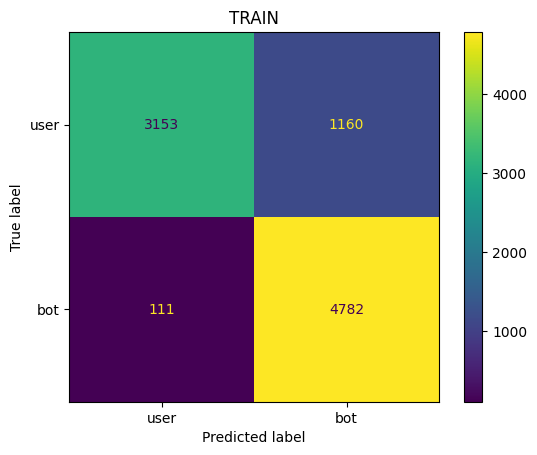

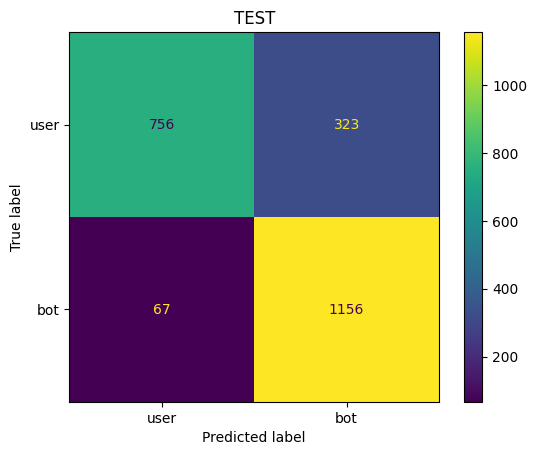

In [15]:
plot_cms(train_pred_dt, test_pred_dt)

### K-nearest neighbors

In [16]:
params = dict(n_neighbors=list(range(1, int(math.sqrt(train_set.shape[0])))))

knn = KNeighborsClassifier()
scores = gridsearch(train_set_scaled, train_label, knn, params)

scores

GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]})

In [17]:
scores.best_params_

{'n_neighbors': 17}

In [18]:
knn = KNeighborsClassifier(**scores.best_params_)
knn = knn.fit(train_set_scaled, train_label)

In [19]:
train_pred_knn = knn.predict(train_set_scaled)
test_pred_knn = knn.predict(test_set_scaled)

predictions["KNN"] = (train_pred_knn, test_pred_knn)

In [20]:
report_scores(train_pred_knn, test_pred_knn)

TRAIN
              precision    recall  f1-score   support

        user       0.89      0.58      0.70      4313
         bot       0.72      0.94      0.81      4893

    accuracy                           0.77      9206
   macro avg       0.80      0.76      0.76      9206
weighted avg       0.80      0.77      0.76      9206

TEST
              precision    recall  f1-score   support

        user       0.88      0.55      0.68      1079
         bot       0.70      0.94      0.80      1223

    accuracy                           0.75      2302
   macro avg       0.79      0.74      0.74      2302
weighted avg       0.79      0.75      0.74      2302



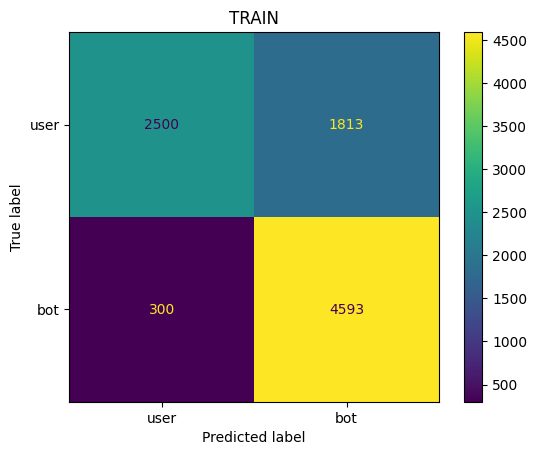

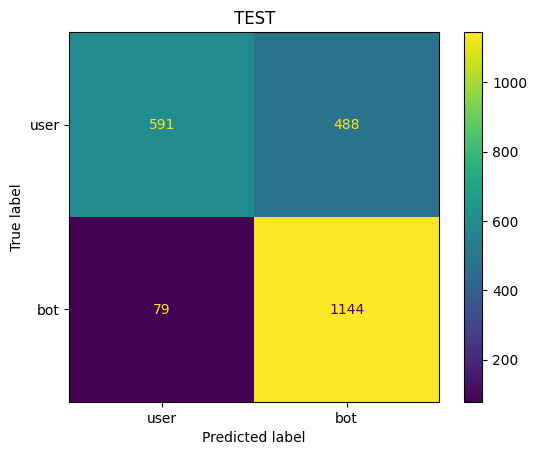

In [21]:
plot_cms(train_pred_knn, test_pred_knn)

### Rule-based

In [22]:
# RIPPER doesn't work with entropy rounded more than 4
train_set_rb = train_set.copy()
train_set_rb['entropy'] = train_set_rb['entropy'].map(lambda x: round(x, 4))

In [23]:
params = dict(
    k=[1, 2, 3],
    prune_size=[0.2, 0.33, 0.5]
)

rb = RIPPER(random_state=0)
scores = gridsearch(train_set_rb, train_label, rb, params)

scores

/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/1_semestre/data_mining/exam/data-mining/venv/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/1_semestre/data_mining/exam/data-mining/venv/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/1_semestre/data_mining/exam/data-mining/venv/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed 

GridSearchCV(cv=4,
             estimator=<RIPPER(dl_allowance=64, prune_size=0.33, max_rule_conds=None, verbosity=0, max_total_conds=None, random_state=0, max_rules=None, n_discretize_bins=10, k=2)>,
             n_jobs=-1,
             param_grid={'k': [1, 2, 3], 'prune_size': [0.2, 0.33, 0.5]})

In [24]:
scores.best_params_

{'k': 1, 'prune_size': 0.5}

In [25]:
rb = RIPPER(random_state=0, **scores.best_params_)
rb.fit(train_set_rb, y=train_label)

List of rules discovered with ripper algorithm.

In [26]:
rb.out_model()

[[entropy=<0.0001 ^ statuses_count=20.0-35.0 ^ mean_texts_similarity=0.0045-0.0079 ^ ratio_likes_x_tweets=>0.97 ^ likes_num=>1413.5 ^ Unnamed:0=8100.5-9215.0] V
[entropy=<0.0001 ^ statuses_count=<20.0] V
[entropy=0.0001-0.0002 ^ statuses_count=45.0-58.0 ^ texts_mean_length=63.0-65.43] V
[entropy=0.0001-0.0002 ^ mean_texts_similarity=0.014-0.015] V
[entropy=<0.0001 ^ statuses_count=20.0-35.0 ^ texts_mean_length=69.91-74.34] V
[entropy=<0.0001 ^ statuses_count=35.0-45.0 ^ mean_pub_range=391753.33-811894.94 ^ comments_num=>2.0] V
[mean_texts_similarity=0.021-0.023 ^ texts_special_chars_length=5.41-5.83 ^ texts_mean_length=82.0-89.53] V
[entropy=<0.0001 ^ statuses_count=20.0-35.0] V
[entropy=0.0001-0.0002 ^ statuses_count=45.0-58.0 ^ ratio_likes_x_tweets=0.066-0.094] V
[entropy=0.0001-0.0002 ^ statuses_count=35.0-45.0 ^ Unnamed:0=>10362.5] V
[entropy=0.0001-0.0002 ^ texts_mean_length=63.0-65.43] V
[entropy=0.0001-0.0002 ^ statuses_count=45.0-58.0] V
[statuses_count=35.0-45.0 ^ texts_mean_l

In [27]:
train_pred_rb = rb.predict(train_set)
test_pred_rb = rb.predict(test_set)

predictions["Rule-based"] = (train_pred_rb, test_pred_rb)

In [28]:
report_scores(train_pred_rb, test_pred_rb)

TRAIN
              precision    recall  f1-score   support

        user       0.76      0.70      0.73      4313
         bot       0.76      0.81      0.78      4893

    accuracy                           0.76      9206
   macro avg       0.76      0.76      0.76      9206
weighted avg       0.76      0.76      0.76      9206

TEST
              precision    recall  f1-score   support

        user       0.79      0.69      0.74      1079
         bot       0.75      0.84      0.80      1223

    accuracy                           0.77      2302
   macro avg       0.77      0.77      0.77      2302
weighted avg       0.77      0.77      0.77      2302



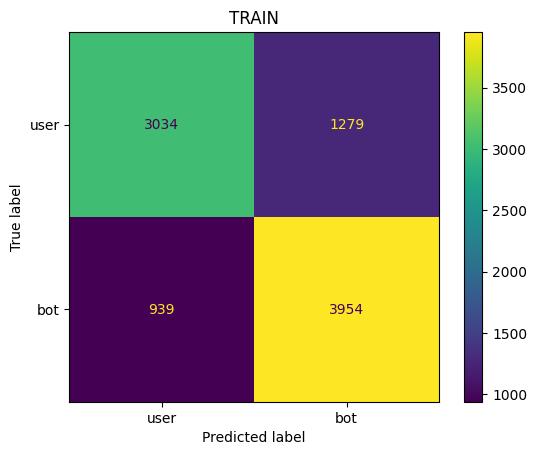

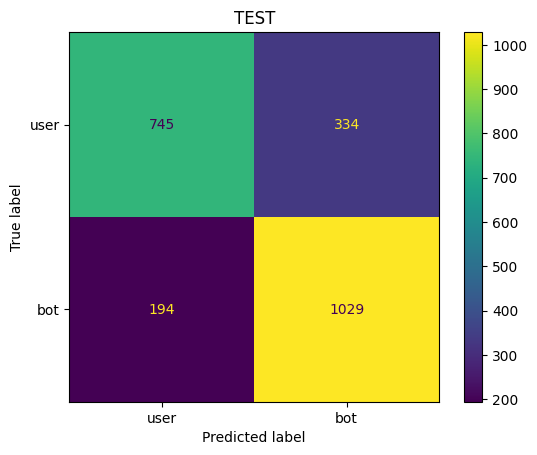

In [29]:
plot_cms(train_pred_rb, test_pred_rb)

### Naive Bayes

In [30]:
nb = GaussianNB()
nb.fit(train_set, train_label)

GaussianNB()

In [31]:
train_pred_nb = nb.predict(train_set)
test_pred_nb = nb.predict(test_set)

predictions["Naive Bayes"] = (train_pred_nb, test_pred_nb)

In [32]:
report_scores(train_pred_nb, test_pred_rb)

TRAIN
              precision    recall  f1-score   support

        user       0.73      0.32      0.44      4313
         bot       0.60      0.90      0.72      4893

    accuracy                           0.63      9206
   macro avg       0.67      0.61      0.58      9206
weighted avg       0.66      0.63      0.59      9206

TEST
              precision    recall  f1-score   support

        user       0.79      0.69      0.74      1079
         bot       0.75      0.84      0.80      1223

    accuracy                           0.77      2302
   macro avg       0.77      0.77      0.77      2302
weighted avg       0.77      0.77      0.77      2302



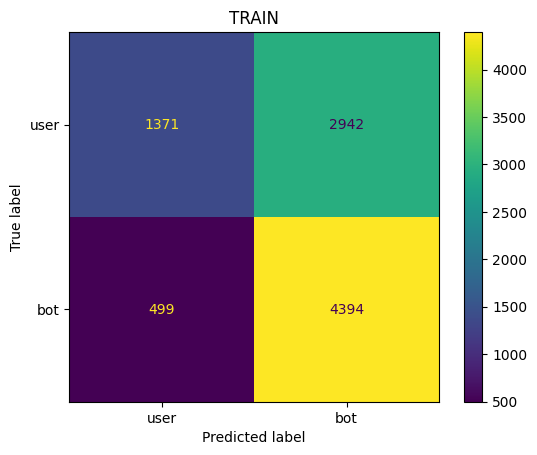

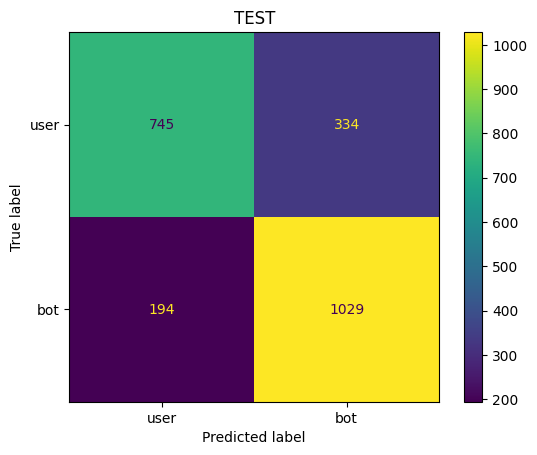

In [33]:
plot_cms(train_pred_nb, test_pred_rb)

### Ensemble methods

#### AdaBoost

In [34]:
params = dict(
    n_estimators=list(range(10, 201, 10)),
    learning_rate=[0.1, 0.3, 0.05, 0.01]
)

boost = AdaBoostClassifier()
scores = gridsearch(train_set, train_label, boost, params)

scores

GridSearchCV(cv=4, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.05, 0.01],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200]})

In [35]:
scores.best_params_

{'learning_rate': 0.3, 'n_estimators': 200}

In [36]:
boost = AdaBoostClassifier(**scores.best_params_)
boost.fit(train_set, train_label)

AdaBoostClassifier(learning_rate=0.3, n_estimators=200)

In [37]:
train_pred_boost = boost.predict(train_set)
test_pred_boost = boost.predict(test_set)

predictions["AdaBoost"] = (train_pred_boost, test_pred_boost)

In [38]:
report_scores(train_pred_boost, test_pred_boost)

TRAIN
              precision    recall  f1-score   support

        user       0.92      0.70      0.79      4313
         bot       0.78      0.94      0.85      4893

    accuracy                           0.83      9206
   macro avg       0.85      0.82      0.82      9206
weighted avg       0.84      0.83      0.82      9206

TEST
              precision    recall  f1-score   support

        user       0.91      0.68      0.78      1079
         bot       0.77      0.94      0.85      1223

    accuracy                           0.82      2302
   macro avg       0.84      0.81      0.81      2302
weighted avg       0.84      0.82      0.82      2302



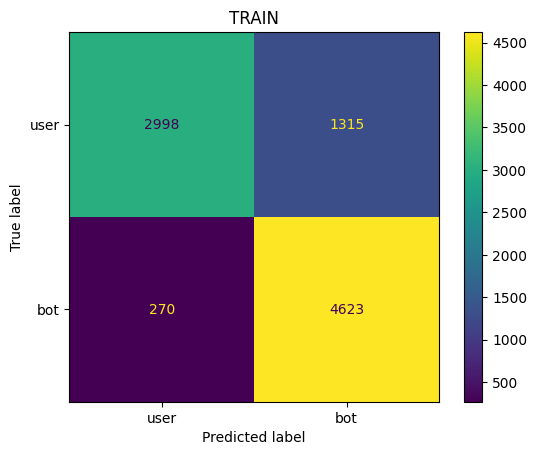

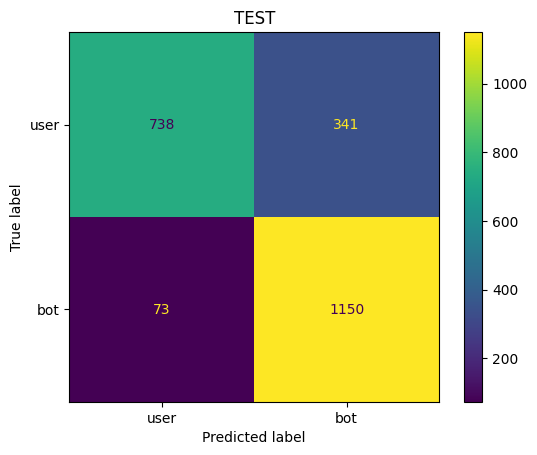

In [39]:
plot_cms(train_pred_boost, test_pred_boost)

#### Random forest

In [40]:
params = dict(n_estimators=list(range(10, 201, 10)))

rf = RandomForestClassifier()
scores = gridsearch(train_set, train_label, rf, params)

scores

GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200]})

In [41]:
scores.best_params_

{'n_estimators': 190}

In [42]:
rf = RandomForestClassifier(**scores.best_params_)
rf.fit(train_set, train_label)

RandomForestClassifier(n_estimators=190)

In [43]:
train_pred_rf = rf.predict(train_set)
test_pred_rf = rf.predict(test_set)

predictions["Random forest"] = (train_pred_rf, test_pred_rf)

In [44]:
report_scores(train_pred_rf, test_pred_rf)

TRAIN
              precision    recall  f1-score   support

        user       1.00      1.00      1.00      4313
         bot       1.00      1.00      1.00      4893

    accuracy                           1.00      9206
   macro avg       1.00      1.00      1.00      9206
weighted avg       1.00      1.00      1.00      9206

TEST
              precision    recall  f1-score   support

        user       0.90      0.71      0.80      1079
         bot       0.79      0.93      0.85      1223

    accuracy                           0.83      2302
   macro avg       0.84      0.82      0.82      2302
weighted avg       0.84      0.83      0.83      2302



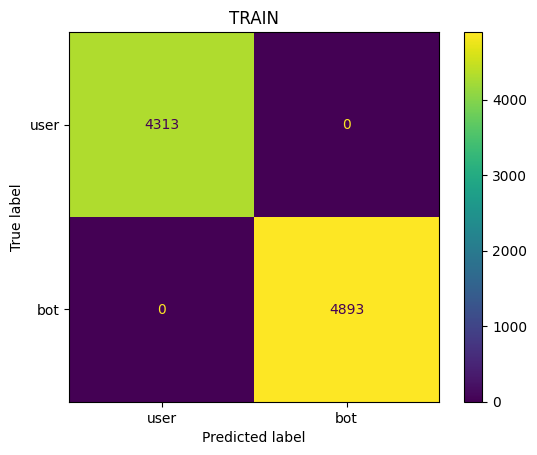

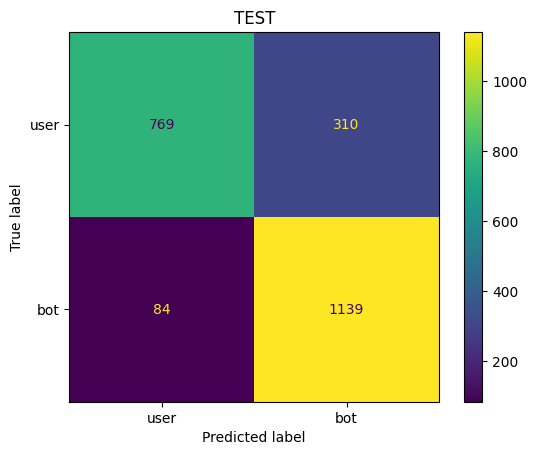

In [45]:
plot_cms(train_pred_rf, test_pred_rf)

### SVM

In [46]:
params = dict(
    kernel=['rbf', 'sigmoid'],
    C=[1, 2, 5]
)

svm = SVC()
scores = gridsearch(train_set_scaled, train_label, svm, params)

scores

GridSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 2, 5], 'kernel': ['rbf', 'sigmoid']})

In [47]:
scores.best_params_

{'C': 5, 'kernel': 'rbf'}

In [48]:
svm = SVC(**scores.best_params_)
svm.fit(train_set_scaled, train_label)

SVC(C=5)

In [49]:
train_pred_svm = svm.predict(train_set_scaled)
test_pred_svm = svm.predict(test_set_scaled)

predictions["SVM"] = (train_pred_svm, test_pred_svm)

In [50]:
report_scores(train_pred_svm, test_pred_svm)

TRAIN
              precision    recall  f1-score   support

        user       0.95      0.51      0.66      4313
         bot       0.69      0.98      0.81      4893

    accuracy                           0.76      9206
   macro avg       0.82      0.74      0.74      9206
weighted avg       0.81      0.76      0.74      9206

TEST
              precision    recall  f1-score   support

        user       0.94      0.50      0.65      1079
         bot       0.69      0.97      0.81      1223

    accuracy                           0.75      2302
   macro avg       0.81      0.74      0.73      2302
weighted avg       0.80      0.75      0.73      2302



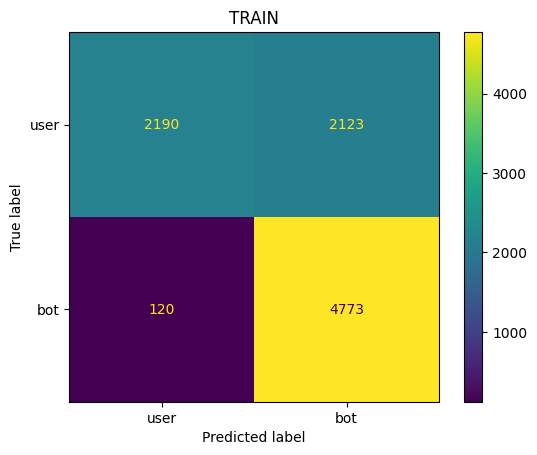

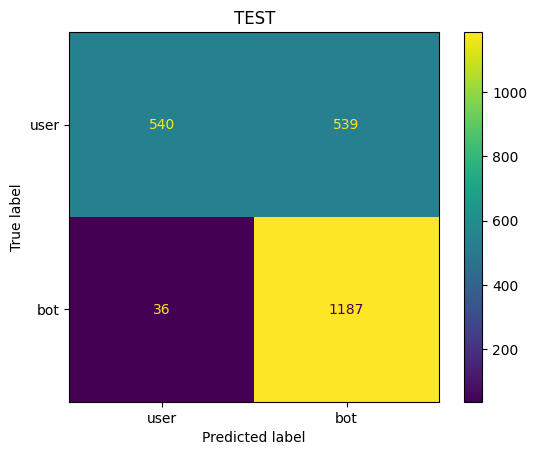

In [51]:
plot_cms(train_pred_svm, test_pred_svm)

### Neural network

In [52]:
x_train_nn = np.reshape(train_set_scaled, (-1, 1, train_set.shape[1]))
x_test_nn = np.reshape(test_set_scaled, (-1, 1, test_set.shape[1]))
y_train_nn = np.asarray(train_label).reshape((-1,1))
y_test_nn = np.asarray(test_label).reshape((-1,1))

In [53]:
def create_nn(hidden_units, hidden_activation):
    nn = keras.models.Sequential([
            keras.layers.Flatten(input_shape=(1, train_set.shape[1])),
            keras.layers.Dense(hidden_units, activation=hidden_activation),
            keras.layers.Dense(1, activation='sigmoid')
        ])
    nn.compile(optimizer='adam',
                      loss='mean_squared_error',
                      metrics=['accuracy'])

    return nn

In [55]:
params = dict(
    model__hidden_units=[32, 64, 128, 516, 1024, 2048],
    model__hidden_activation=['sigmoid', 'relu', 'tanh']
)

nn = KerasClassifier(model=create_nn, epochs = 100, batch_size = 516)
scores = gridsearch(x_train_nn, y_train_nn, nn, params)

scores

2022-12-29 06:49:01.618637: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-29 06:49:01.621292: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-29 06:49:01.632523: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-29 06:49:01.642445: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-29 06:49:01.664252: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-29 06:49:01.672581: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-29 06:49:01.802148: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100


2022-12-29 06:49:01.924568: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2658 - accuracy: 0.5316
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2969 - accuracy: 0.5316
Epoch 2/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2510 - accuracy: 0.5316
Epoch 2/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2583 - accuracy: 0.5316
Epoch 2/100
Epoch 3/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2447 - accuracy: 0.5362
Epoch 4/100
14/14 [==============================] - 0s 957us/step - loss: 0.2434 - accuracy: 0.5576
Epoch 4/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2442 - accuracy: 0.5603
Epoch 4/100
14/14 [==============================] - 0s 912us/step - loss: 0.2411 - accuracy: 0.5983
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2515 - accuracy: 0.5169
Epoch 2/100
14/14 [==============================] - 0s 927us/step - loss: 0.2393 - accuracy:

2022-12-29 06:49:54.864823: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


18/18 [==============================] - 0s 3ms/step - loss: 0.2341 - accuracy: 0.6301
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2260 - accuracy: 0.6373
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2234 - accuracy: 0.6369
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2208 - accuracy: 0.6399
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2176 - accuracy: 0.6489
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2135 - accuracy: 0.6536
Epoch 7/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2097 - accuracy: 0.6626
Epoch 8/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2060 - accuracy: 0.6880
Epoch 9/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2018 - accuracy: 0.6952
Epoch 10/100
18/18 [==============================] - 0s 3ms/step - loss: 0.1996 - accuracy: 0.7012
Epoch 11/100
18/18 [=

GridSearchCV(cv=4,
             estimator=KerasClassifier(batch_size=516, epochs=100, model=<function create_nn at 0x285c600d0>),
             n_jobs=-1,
             param_grid={'model__hidden_activation': ['sigmoid', 'relu',
                                                      'tanh'],
                         'model__hidden_units': [32, 64, 128, 516, 1024, 2048]})

In [56]:
scores.best_params_

{'model__hidden_activation': 'relu', 'model__hidden_units': 2048}

In [57]:
best_params = {k.replace('model__', ''): v for k, v in scores.best_params_.items()}

nn = create_nn(**best_params)
nn.fit(x_train_nn, y_train_nn, epochs = 100, batch_size = 516)

Epoch 1/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2326 - accuracy: 0.6277
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2259 - accuracy: 0.6364
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2236 - accuracy: 0.6369
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2208 - accuracy: 0.6396
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2180 - accuracy: 0.6462
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 0.2143 - accuracy: 0.6577
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2101 - accuracy: 0.6672
Epoch 8/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2058 - accuracy: 0.6708
Epoch 9/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2021 - accuracy: 0.6928
Epoch 10/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1981 - accuracy: 0.7067
Epoch 11/

In [58]:
train_pred_nn = (nn.predict(x_train_nn) > 0.5).astype("int32")
test_pred_nn = (nn.predict(x_test_nn) > 0.5).astype("int32")

predictions["Neural network"] = (train_pred_nn, test_pred_nn)

72/72 [==============================] - 0s 338us/step


In [59]:
report_scores(train_pred_nn, test_pred_nn)

TRAIN
              precision    recall  f1-score   support

        user       0.93      0.59      0.72      4313
         bot       0.73      0.96      0.83      4893

    accuracy                           0.79      9206
   macro avg       0.83      0.77      0.77      9206
weighted avg       0.82      0.79      0.78      9206

TEST
              precision    recall  f1-score   support

        user       0.93      0.59      0.72      1079
         bot       0.73      0.96      0.83      1223

    accuracy                           0.78      2302
   macro avg       0.83      0.77      0.77      2302
weighted avg       0.82      0.78      0.78      2302



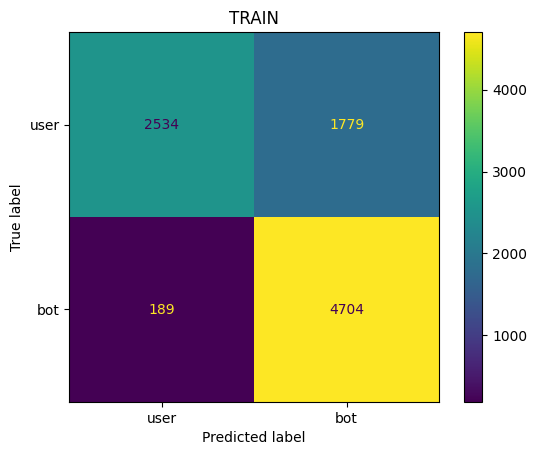

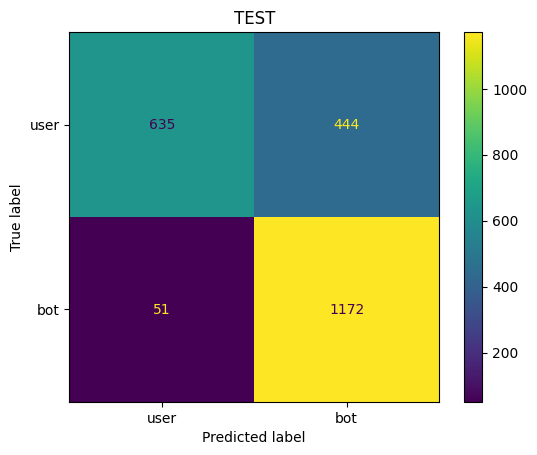

In [60]:
plot_cms(train_pred_nn, test_pred_nn)

## Comparisons

In [61]:
def plot_roc(roc_type="test"):
    plt.figure(0).clf()
    is_test = roc_type == "test"
    index = 1 if is_test else 0

    for key, value in predictions.items():
        pred = value[index]
        label = test_label if is_test else train_label
        fpr, tpr, thresh = metrics.roc_curve(label, pred)
        auc = metrics.roc_auc_score(label, pred)
        plt.plot(fpr,tpr,label=f"{key}, auc="+str(round(auc, 2)))
        plt.title("Test" if is_test else "Train")

    plt.legend(loc=0)

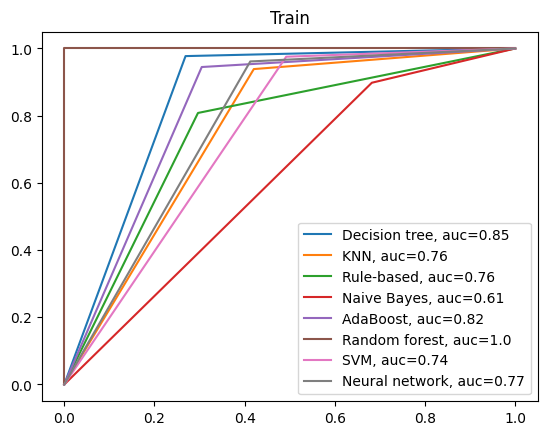

In [62]:
plot_roc("train")

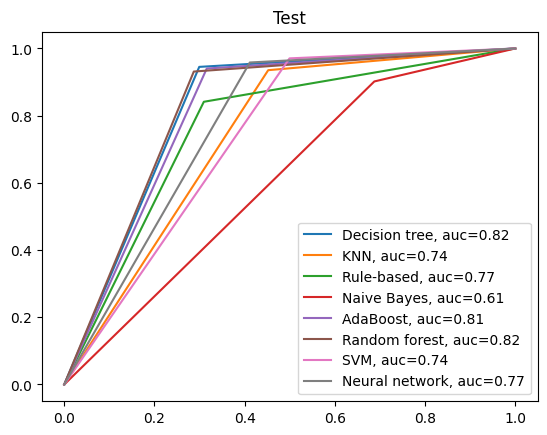

In [63]:
plot_roc("test")